# ASSESSING THE ROLE OF POWER GRID INFRASTRUCTURE IN WILDFIRE IGNITION

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import geopandas as gpd
from datetime import datetime

## load data
 - fire data FPA-FOD: California 1992-2020
 - air temp data: California 1992-2024
 - soil moisture data: California 1992-2024
 - wind speed data: California 1992-2024
 - California transmission_line data
 - Burned area data: California 2000-2024
 - Vegetation indices data: California 2000-2024

In [30]:
fire_data = pd.read_csv('../data/CA/ca_data.csv')
print("Fire data shape:", fire_data.shape)
print("\nFire data columns:", fire_data.columns.tolist())
fire_data.head()

# Environmental data
temp_data = pd.read_csv('../data/NARR/california_air_temperature.csv')
moisture_data = pd.read_csv('../data/NARR/california_soil_moisture.csv')
wind_data = pd.read_csv('../data/NARR/california_wind_speed.csv')
burned_area = pd.read_csv('../data/NASA/california_burn_area.csv')
vegetation_indicies = pd.read_csv('../data/NASA/california_vegetation_indices.csv')

# Transmission line data
transmission_data = gpd.read_file('../data/transmission/Transmission_Line.geojson')


/var/folders/4c/0zt2zr712xn0rtz1d_xhxpgm0000gn/T/ipykernel_17111/2129592583.py:1: DtypeWarning: Columns (11,12,35) have mixed types. Specify dtype option on import or set low_memory=False.
  fire_data = pd.read_csv('../data/CA/ca_data.csv')


Fire data shape: (251881, 38)

Fire data columns: ['Unnamed: 0', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'NWCG_CAUSE_AGE_CATEGORY', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME']


## Data Prepare

### Fire data

#### fire data cleaning

In [31]:
# Select relevant columns
relevant_columns = [
    'FIRE_YEAR',
    'DISCOVERY_DATE',
    'DISCOVERY_TIME',
    'NWCG_CAUSE_CLASSIFICATION',
    'NWCG_GENERAL_CAUSE',
    'FIRE_SIZE',
    'FIRE_SIZE_CLASS',
    'LATITUDE',
    'LONGITUDE',
    'COUNTY',
    'CONT_DATE',
    'CONT_TIME'
]

# Create initial cleaned dataset
fire_data_cleaned = fire_data[relevant_columns].copy()

# Filter for years 2000-2020
fire_data_cleaned = fire_data_cleaned[
    (fire_data_cleaned['FIRE_YEAR'] >= 2000) & 
    (fire_data_cleaned['FIRE_YEAR'] <= 2020)
]

# Drop rows with missing critical information
fire_data_cleaned = fire_data_cleaned.dropna(subset=['LATITUDE', 'LONGITUDE', 'FIRE_SIZE'])

In [32]:
# 4. Create grid reference system
def create_grid_reference():
    """Create 0.1-degree resolution grid for California"""
    x_bins = np.arange(-124.5, -114, 0.1)  # longitude
    y_bins = np.arange(32.5, 42, 0.1)      # latitude
    
    print(f"Grid size: {len(x_bins)} x {len(y_bins)} cells")
    return x_bins, y_bins

# 5. Function to find grid cell indices
def get_grid_indices(lon, lat, x_bins, y_bins):
    """Get grid cell indices for a given location"""
    x_idx = int((lon - x_bins[0]) / 0.1)
    y_idx = int((lat - y_bins[0]) / 0.1)
    # Ensure indices are within bounds
    x_idx = max(0, min(x_idx, len(x_bins)-1))
    y_idx = max(0, min(y_idx, len(y_bins)-1))
    return x_idx, y_idx

# 6. Assign grid cells
def assign_grid_cells(data, x_bins, y_bins):
    """Assign grid cell IDs to each point in the dataset"""
    # Create separate columns for x and y indices
    data['x_idx'] = data.apply(lambda row: get_grid_indices(row['LONGITUDE'], 
                                                          row['LATITUDE'], 
                                                          x_bins, 
                                                          y_bins)[0], axis=1)
    data['y_idx'] = data.apply(lambda row: get_grid_indices(row['LONGITUDE'], 
                                                          row['LATITUDE'], 
                                                          x_bins, 
                                                          y_bins)[1], axis=1)
    return data

x_bins, y_bins = create_grid_reference()
fire_data_cleaned = assign_grid_cells(fire_data_cleaned, x_bins, y_bins)


Grid size: 105 x 95 cells


In [33]:
print(fire_data_cleaned.head(10))

   FIRE_YEAR     DISCOVERY_DATE  DISCOVERY_TIME NWCG_CAUSE_CLASSIFICATION  \
0       2005  02/02/05 00:00:00          1300.0                     Human   
1       2004  05/12/04 00:00:00           845.0                   Natural   
2       2004  05/31/04 00:00:00          1921.0                     Human   
3       2004  06/28/04 00:00:00          1600.0                   Natural   
4       2004  06/28/04 00:00:00          1600.0                   Natural   
5       2004  06/30/04 00:00:00          1800.0                   Natural   
6       2004  07/01/04 00:00:00          1800.0                   Natural   
7       2005  03/08/05 00:00:00          1300.0                     Human   
8       2005  03/15/05 00:00:00          1200.0                     Human   
9       2004  07/01/04 00:00:00          1800.0                   Natural   

                           NWCG_GENERAL_CAUSE  FIRE_SIZE FIRE_SIZE_CLASS  \
0  Power generation/transmission/distribution       0.10               A   


In [34]:
def calculate_fire_frequency(data, x_bins, y_bins):
    """Calculate annual fire frequency for each grid cell"""
    # Create a grid to store fire counts
    grid_counts = np.zeros((len(y_bins), len(x_bins)))
    
    # Count fires in each grid cell
    for _, row in data.iterrows():
        grid_counts[row['y_idx'], row['x_idx']] += 1
    
    # Convert to annual frequency
    years = data['FIRE_YEAR'].max() - data['FIRE_YEAR'].min() + 1
    grid_counts = grid_counts / years
    
    return grid_counts

grid_data = calculate_fire_frequency(fire_data_cleaned, x_bins, y_bins)

#### Environmental Data

In [38]:
# Filter for years 2000–2020
def ensure_datetime(df, column_name='date'):
    if column_name in df.columns:
        df[column_name] = pd.to_datetime(df[column_name], errors='coerce')
    return df

# Apply to all datasets
temp_data = ensure_datetime(temp_data)
moisture_data = ensure_datetime(moisture_data)
wind_data = ensure_datetime(wind_data)
burned_area = ensure_datetime(burned_area)
vegetation_indicies = ensure_datetime(vegetation_indicies)

# Drop redundant columns only if they exist
def drop_columns_safely(df, columns_to_drop):
    existing_columns = [col for col in columns_to_drop if col in df.columns]
    return df.drop(columns=existing_columns)

temp_data = drop_columns_safely(temp_data, ['year', 'month'])
moisture_data = drop_columns_safely(moisture_data, ['year', 'month'])
wind_data = drop_columns_safely(wind_data, ['year', 'month'])
def filter_years(df, start_year, end_year):
    if 'year' in df.columns:
        return df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    else:
        df['date'] = pd.to_datetime(df['date'])
        return df[(df['date'].dt.year >= start_year) & (df['date'].dt.year <= end_year)]

temp_data = filter_years(temp_data, 2000, 2020)
moisture_data = filter_years(moisture_data, 2000, 2020)
wind_data = filter_years(wind_data, 2000, 2020)
burned_area = filter_years(burned_area, 2000, 2020)
vegetation_indicies = filter_years(vegetation_indicies, 2000, 2020)

# Debugging print statements to ensure columns and shapes are correct
print(temp_data.columns)
print(temp_data.shape)
print(moisture_data.columns)
print(moisture_data.shape)
print(wind_data.columns)
print(wind_data.shape)

# Drop redundant columns safely
temp_data = drop_columns_safely(temp_data, ['year', 'month'])
moisture_data = drop_columns_safely(moisture_data, ['year', 'month'])
wind_data = drop_columns_safely(wind_data, ['year', 'month'])

# Merge datasets on 'date', 'lat', and 'lon'
env_data = temp_data.merge(moisture_data, on=['date', 'lat', 'lon'], how='inner')
env_data = env_data.merge(wind_data, on=['date', 'lat', 'lon'], how='inner')

# Merge burned area data (use 'date' as the key)
env_data = env_data.merge(burned_area, on='date', how='inner')

# Merge vegetation indices (use 'date' as the key)
env_data = env_data.merge(vegetation_indicies, on='date', how='inner')

# Inspect final dataset
print(env_data.info())
print(env_data.head())


# Save merged data for modeling
#env_data.to_csv('../data/processed/environmental_data_cleaned.csv', index=False)

Index(['date', 'lat', 'lon', 'air'], dtype='object')
(273420, 4)
Index(['date', 'lat', 'lon', 'soilm'], dtype='object')
(273420, 4)
Index(['date', 'lat', 'lon', 'vwnd'], dtype='object')
(273420, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29295 entries, 0 to 29294
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 29295 non-null  datetime64[ns]
 1   lat                  29295 non-null  float64       
 2   lon                  29295 non-null  float64       
 3   air                  29295 non-null  float64       
 4   soilm                29295 non-null  object        
 5   vwnd                 29295 non-null  float64       
 6   burned_area_m2       29295 non-null  float64       
 7   burned_pixels        29295 non-null  float64       
 8   total_pixels         29295 non-null  int64         
 9   burned_area_ha       29295 non-null  float64       
 10  perc

### Transmission Line Data

Having only current (2023/2024) power line data but historical fire data (2000-2020) introduces a temporal mismatch that could significantly affect your analysis:
Key Issues:

Power infrastructure changes over time:

 - New lines being built
 - Old lines being decommissioned
 - Upgrades/modifications to existing lines
 - Changes in maintenance practices


Potential biases:

 - You might be associating historical fires with power lines that didn't exist then
 - Or missing associations with power lines that existed then but not now
 - Maintenance frequency data would be based on current practices, not historical ones

In [39]:
print("Data Shape:", transmission_data.shape)
print("\nColumns:", transmission_data.columns.tolist())
print("\nSample of the data:")
print(transmission_data.head())

Data Shape: (6839, 20)

Columns: ['OBJECTID', 'Name', 'kV', 'kV_Sort', 'Owner', 'Status', 'Circuit', 'Type', 'Legend', 'Length_Mile', 'Length_Feet', 'TLine_Name', 'Source', 'Comments', 'Creator', 'Creator_Date', 'Last_Editor', 'Last_Editor_Date', 'GlobalID', 'geometry']

Sample of the data:
   OBJECTID       Name   kV  kV_Sort Owner       Status Circuit Type  \
0         1  AMP 115kV  115    115.0   AMP  Operational  Single   OH   
1         2  AMP 115kV  115    115.0   AMP  Operational  Single   OH   
2         3  AMP 115kV  115    115.0   AMP  Operational  Single   OH   
3         4  AMP 115kV  115    115.0   AMP  Operational  Single   OH   
4         5  ANZA 34kV   34     34.0  ANZA  Operational  Single   OH   

            Legend  Length_Mile      Length_Feet TLine_Name        Source  \
0  Other_110_161kV          2.0   10879.98077483                      AMP   
1  Other_110_161kV          3.0   16505.41123852                      AMP   
2  Other_110_161kV          1.0    3807.2401

In [40]:
# Convert Creator_Date to datetime format
transmission_data['Creator_Date'] = pd.to_datetime(transmission_data['Creator_Date'], errors='coerce')

# Get the current date
current_date = pd.Timestamp.now()

# Calculate the age of the transmission line in years
transmission_data['line_age_years'] = (current_date - transmission_data['Creator_Date']).dt.total_seconds() / (365.25 * 24 * 3600)

# Handle missing or invalid dates (NaT from errors='coerce')
transmission_data['line_age_years'] = transmission_data['line_age_years'].fillna(-1)  # Use -1 for missing data

# Add categorical features
transmission_data['kV_category'] = transmission_data['kV'].astype(str)
transmission_data['kV_category'] = (transmission_data['kV_category']
                                  .replace('nan', 'Unknown')
                                  .replace('None', 'Unknown')
                                  .replace(' ', 'Unknown')
                                  .replace('', 'Unknown'))

# Add binary features
transmission_data['is_operational'] = (transmission_data['Status'] == 'Operational').astype(int)
transmission_data['is_single_circuit'] = (transmission_data['Circuit'] == 'Single').astype(int)
transmission_data['is_overhead'] = (transmission_data['Type'] == 'OH').astype(int)

# Check the resulting DataFrame
print(transmission_data.info())
print(transmission_data.head())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6839 entries, 0 to 6838
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   OBJECTID           6839 non-null   int32         
 1   Name               6834 non-null   object        
 2   kV                 6834 non-null   object        
 3   kV_Sort            6811 non-null   float64       
 4   Owner              6823 non-null   object        
 5   Status             6835 non-null   object        
 6   Circuit            6821 non-null   object        
 7   Type               6822 non-null   object        
 8   Legend             6822 non-null   object        
 9   Length_Mile        6787 non-null   float64       
 10  Length_Feet        6798 non-null   object        
 11  TLine_Name         6724 non-null   object        
 12  Source             6821 non-null   object        
 13  Comments           6773 non-null   object        
 14  

In [21]:
print(transmission_data.columns.tolist())

['OBJECTID', 'Name', 'kV', 'kV_Sort', 'Owner', 'Status', 'Circuit', 'Type', 'Legend', 'Length_Mile', 'Length_Feet', 'TLine_Name', 'Source', 'Comments', 'Creator', 'Creator_Date', 'Last_Editor', 'Last_Editor_Date', 'GlobalID', 'geometry', 'line_age_years', 'kV_category', 'is_operational', 'is_single_circuit', 'is_overhead']


In [41]:
#Density
from shapely.geometry import box

def calculate_line_density_features(transmission_data, buffer_radius=0.1):
    """
    Calculate density features for each transmission line using kV_Sort
    """
    # Remove any existing density columns to avoid duplication
    cols_to_keep = [col for col in transmission_data.columns if not col.startswith('nearby_')]
    transmission_data = transmission_data[cols_to_keep]
    
    # Initialize density features
    density_features = []
    print("Processing", len(transmission_data), "lines")
    
    # For each transmission line
    for idx, line in transmission_data.iterrows():
        try:
            # Create a buffer around the current line
            current_buffer = line.geometry.buffer(buffer_radius)
            
            # Find nearby lines using spatial intersection
            nearby_lines = transmission_data[transmission_data.geometry.intersects(current_buffer)]
            # Remove the current line from nearby lines
            nearby_lines = nearby_lines[nearby_lines.index != idx]
            
            # Calculate density metrics
            density_metrics = {
                'nearby_line_count': len(nearby_lines),
                'nearby_total_length': nearby_lines['Length_Mile'].sum(),
                'nearby_avg_voltage': nearby_lines['kV_Sort'].mean() if len(nearby_lines) > 0 else 0,
                'nearby_max_voltage': nearby_lines['kV_Sort'].max() if len(nearby_lines) > 0 else 0,
                'nearby_operational_count': nearby_lines['is_operational'].sum() if len(nearby_lines) > 0 else 0
            }
            
        except Exception as e:
            print(f"Error processing line {idx}: {str(e)}")
            density_metrics = {
                'nearby_line_count': 0,
                'nearby_total_length': 0,
                'nearby_avg_voltage': 0,
                'nearby_max_voltage': 0,
                'nearby_operational_count': 0
            }
        
        density_features.append(density_metrics)
        
        # Print progress every 1000 lines
        if len(density_features) % 1000 == 0:
            print(f"Processed {len(density_features)} lines")
    
    # Convert to DataFrame with matching index
    density_df = pd.DataFrame(density_features, index=transmission_data.index)
    
    # Print summary of the new features
    print("\nDensity features summary:")
    print(density_df.describe())
    
    # Join with original data
    result = pd.concat([transmission_data, density_df], axis=1)
    
    return result

transmission_data = calculate_line_density_features(transmission_data)

Processing 6839 lines
Processed 1000 lines
Processed 2000 lines
Processed 3000 lines
Processed 4000 lines
Processed 5000 lines
Processed 6000 lines

Density features summary:
       nearby_line_count  nearby_total_length  nearby_avg_voltage  \
count        6839.000000          6839.000000         6839.000000   
mean           67.564264           341.275771          125.173100   
std            61.006220           272.765655           50.886455   
min             0.000000             0.000000            0.000000   
25%            20.000000           174.000000           91.558586   
50%            47.000000           279.000000          112.187500   
75%            98.000000           426.000000          148.051587   
max           548.000000          3292.000000          500.000000   

       nearby_max_voltage  nearby_operational_count  
count         6839.000000               6839.000000  
mean           308.112297                 67.180436  
std            144.620590                

In [42]:
# Define essential columns (as before)
essential_columns = [
    # Core transmission line characteristics
    'geometry',           # Spatial geometry (required for spatial analysis)
    'kV_Sort',           # Voltage level (numerical)
    'kV_category',       # Voltage category (including DC lines)
    'Length_Mile',       # Line length
    'Status',            # Operational status
    'Circuit',           # Circuit type
    'Type',              # Line type (e.g., overhead)
    
    # Temporal information
    'Creator_Date',      # Installation/creation date
    'Last_Editor_Date',  # Last maintenance date
    'line_age_years',    # Age of the line
    
    # Binary features we created
    'is_operational',
    'is_single_circuit',
    'is_overhead',
    
    # Density features we calculated
    'nearby_line_count',
    'nearby_total_length',
    'nearby_avg_voltage',
    'nearby_max_voltage',
    'nearby_operational_count'
]

# Create cleaned dataset while maintaining GeoDataFrame type
transmission_data_cleaned = gpd.GeoDataFrame(transmission_data[essential_columns], geometry='geometry')

# Verify it's still a GeoDataFrame with geometry
print("\nVerifying geometric properties:")
print("Type:", type(transmission_data_cleaned))
print("CRS:", transmission_data_cleaned.crs)
print("Has geometry column:", 'geometry' in transmission_data_cleaned.columns)


Verifying geometric properties:
Type: <class 'geopandas.geodataframe.GeoDataFrame'>
CRS: EPSG:4326
Has geometry column: True



Maintenance Features Summary:

Days since last maintenance:
count    6822.000000
mean     3144.756444
std         1.625900
min      3010.484243
25%      3144.775759
50%      3144.776153
75%      3144.776442
max      3144.776778
Name: days_since_last_edit, dtype: float64

Maintenance period (days):
count    6822.000000
mean     2230.957676
std       361.263612
min        46.309479
25%      2028.644965
50%      2135.644572
75%      2593.644097
max      2909.644225
Name: maintenance_period_days, dtype: float64


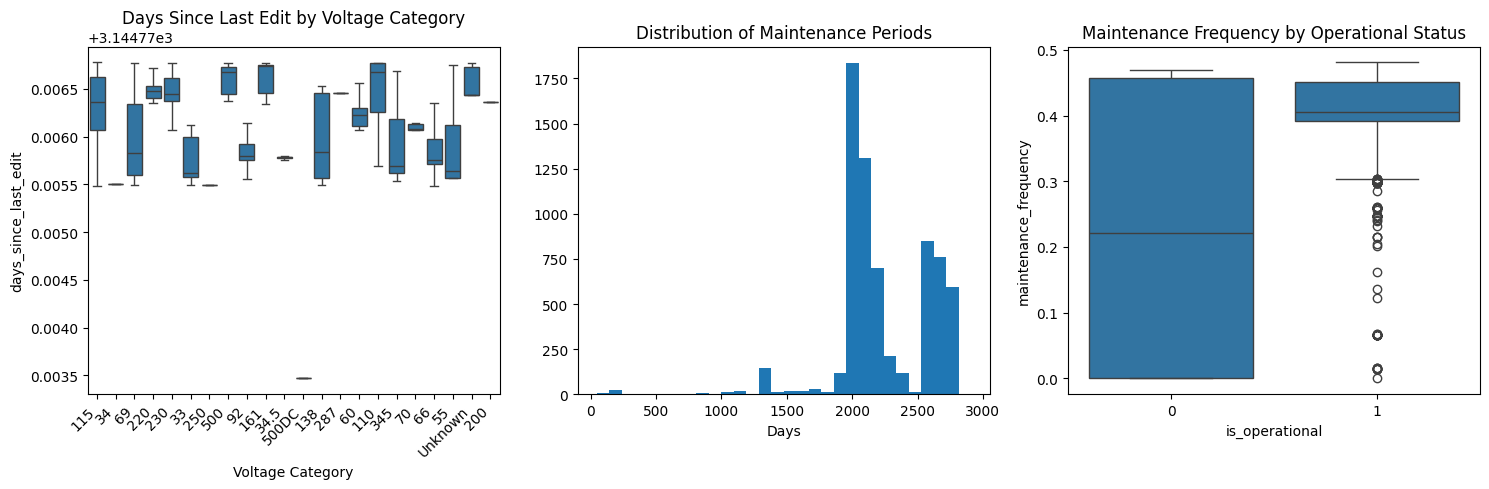

In [43]:
def add_maintenance_features(transmission_data_cleaned):
    """
    Add maintenance-related features to the transmission line dataset
    """
    # Ensure dates are in datetime format
    transmission_data_cleaned['Creator_Date'] = pd.to_datetime(transmission_data_cleaned['Creator_Date'])
    transmission_data_cleaned['Last_Editor_Date'] = pd.to_datetime(transmission_data_cleaned['Last_Editor_Date'])
    
    # Calculate maintenance features
    current_date = pd.Timestamp.now()
    
    # Time since last maintenance
    transmission_data_cleaned['days_since_last_edit'] = (
        current_date - transmission_data_cleaned['Last_Editor_Date']
    ).dt.total_seconds() / (24 * 3600)
    
    # Total maintenance period (time between creation and last edit)
    transmission_data_cleaned['maintenance_period_days'] = (
        transmission_data_cleaned['Last_Editor_Date'] - transmission_data_cleaned['Creator_Date']
    ).dt.total_seconds() / (24 * 3600)
    
    # Maintenance frequency (maintenance period relative to age)
    transmission_data_cleaned['maintenance_frequency'] = (
        transmission_data_cleaned['maintenance_period_days'] / 
        transmission_data_cleaned['line_age_years'] / 365
    ).fillna(0)
    
    # Print summary statistics
    print("\nMaintenance Features Summary:")
    print("\nDays since last maintenance:")
    print(transmission_data_cleaned['days_since_last_edit'].describe())
    
    print("\nMaintenance period (days):")
    print(transmission_data_cleaned['maintenance_period_days'].describe())
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Days Since Last Edit by Voltage Category (without outliers)
    plt.subplot(1, 3, 1)
    sns.boxplot(data=transmission_data_cleaned, 
                x='kV_category', 
                y='days_since_last_edit',
                showfliers=False)
    plt.title('Days Since Last Edit by Voltage Category')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Voltage Category')
    
    # Plot 2: Maintenance Period Distribution
    plt.subplot(1, 3, 2)
    plt.hist(transmission_data_cleaned['maintenance_period_days'], bins=30)
    plt.title('Distribution of Maintenance Periods')
    plt.xlabel('Days')
    
    # Plot 3: Maintenance Frequency by Operational Status
    plt.subplot(1, 3, 3)
    sns.boxplot(data=transmission_data_cleaned, x='is_operational', y='maintenance_frequency')
    plt.title('Maintenance Frequency by Operational Status')
    
    plt.tight_layout()
    plt.show()
    
    return transmission_data_cleaned

transmission_data_cleaned = add_maintenance_features(transmission_data_cleaned)

# print("\nNew maintenance features added:")
# maintenance_columns = [
#     'days_since_last_edit',
#     'maintenance_period_days',
#     'maintenance_frequency'
# ]
# print(transmission_data_cleaned[maintenance_columns].head())

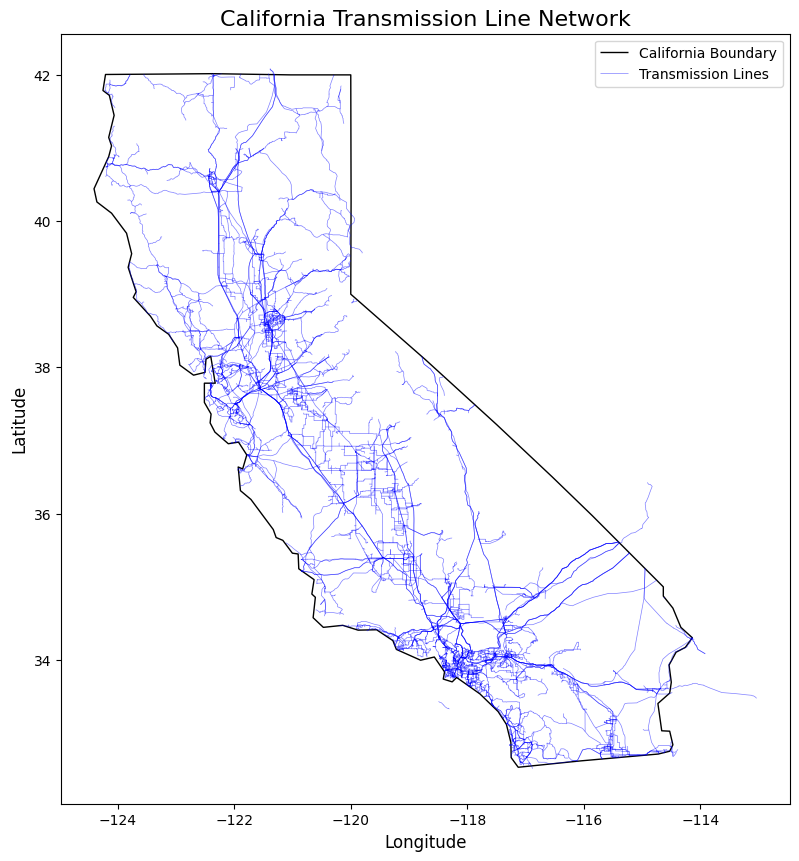

In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load California boundary shapefile (example from GeoPandas sample data)
california_boundary = gpd.read_file("https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json")
california_boundary = california_boundary[california_boundary['id'] == 'CA']

# Create visualization of the transmission lines
fig, ax = plt.subplots(figsize=(15, 10))

# Plot California boundary
california_boundary.boundary.plot(
    ax=ax,
    color='black',
    linewidth=1,
    label='California Boundary'
)

# Plot the transmission lines
transmission_data_cleaned.plot(
    ax=ax,
    color='blue',
    alpha=0.5,
    linewidth=0.5,
    label='Transmission Lines'
)

# Set title and axis labels
plt.title('California Transmission Line Network', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Disable grid lines
ax.grid(False)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
output_geojson_path = "../data/processed/transmission_data_cleaned.geojson"
transmission_data_cleaned.to_file(output_geojson_path, driver="GeoJSON")

In [45]:
from shapely.geometry import box
import geopandas as gpd
import numpy as np

# Define California bounding box (approximate; adjust as needed)
min_lon, min_lat, max_lon, max_lat = -125.0, 32.0, -114.0, 42.0

# Create grid with 0.1-degree resolution
grid_cells = []
x_coords = np.arange(min_lon, max_lon, 0.1)
y_coords = np.arange(min_lat, max_lat, 0.1)

for x in x_coords:
    for y in y_coords:
        grid_cells.append(box(x, y, x + 0.1, y + 0.1))  # Create a grid cell (polygon)

# Convert grid cells to GeoDataFrame
grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:3310")

# Add unique pixel IDs
grid_gdf['pixel_id'] = range(len(grid_gdf))

/var/folders/4c/0zt2zr712xn0rtz1d_xhxpgm0000gn/T/ipykernel_17111/836618817.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlOrRd', 4)  # Sequential colormap with 4 discrete levels


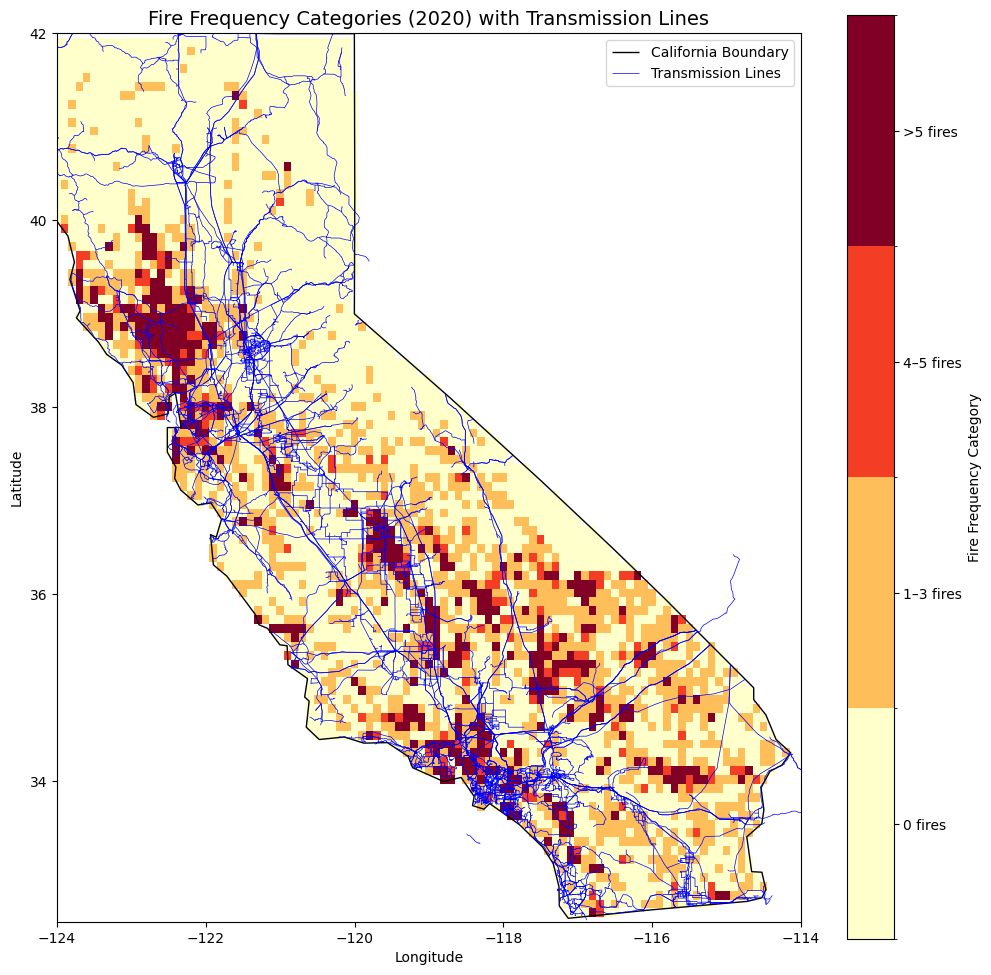

In [78]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_fire_categories_with_powerlines_new_colors(grid_data, x_bins, y_bins, transmission_data, year=2020):
    """
    Plot categorized fire frequency with powerlines overlay using a new colormap.
    """
    # Categorize fire frequency
    fire_categories = categorize_fire_frequency(grid_data)

    # Load California boundary shapefile
    california = gpd.read_file('https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/us-states.json')
    california = california[california['id'] == 'CA']
    
    # Adjust x_bins and y_bins to match the grid dimensions
    x_bins = x_bins[:-1]
    y_bins = y_bins[:-1]
    
    # Create meshgrid for plotting
    xx, yy = np.meshgrid(x_bins, y_bins)
    
    # Create a mask for points within California boundaries
    california_shape = california.geometry.iloc[0]
    mask = np.array([[california_shape.contains(Point(x, y)) for x in x_bins] for y in y_bins])
    
    # Apply mask to fire categories
    masked_data = np.ma.masked_array(fire_categories, ~mask)

    # Define a new sequential colormap for categories
    cmap = plt.cm.get_cmap('YlOrRd', 4)  # Sequential colormap with 4 discrete levels
    bounds = [0, 1, 2, 3, 4]  # Boundaries for categories
    norm = BoundaryNorm(bounds, cmap.N)

    # Plot the data
    fig, ax = plt.subplots(figsize=(12, 12))
    fire_plot = ax.pcolormesh(xx, yy, masked_data, cmap=cmap, norm=norm, shading='auto')
    cbar = plt.colorbar(fire_plot, ax=ax, ticks=[0.5, 1.5, 2.5, 3.5], label='Fire Frequency Category')
    cbar.ax.set_yticklabels(['0 fires', '1–3 fires', '4–5 fires', '>5 fires'])
    
    # Overlay California boundary
    california.boundary.plot(ax=ax, edgecolor='black', linewidth=1, label='California Boundary')

    # Overlay transmission lines
    transmission_data.plot(ax=ax, color='blue', alpha=1.0, linewidth=0.5, label='Transmission Lines')

    # Set plot limits, labels, and title
    plt.xlim(-124, -114)
    plt.ylim(32.5, 42)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Fire Frequency Categories (2020) with Transmission Lines', fontsize=14)
    
    # Add legend
    ax.legend(loc='upper right', fontsize=10)
    
    plt.show()

# Example Usage
plot_fire_categories_with_powerlines_new_colors(grid_data, x_bins, y_bins, transmission_data_cleaned, year=2020)


In [ ]:
grid_gdf

,geometry,pixel_id,line_density
0,"POLYGON ((-124.9 32, -124.9 32.1, -125 32.1, -...",0,0.0
1,"POLYGON ((-124.9 32.1, -124.9 32.2, -125 32.2,...",1,0.0
2,"POLYGON ((-124.9 32.2, -124.9 32.3, -125 32.3,...",2,0.0
3,"POLYGON ((-124.9 32.3, -124.9 32.4, -125 32.4,...",3,0.0
4,"POLYGON ((-124.9 32.4, -124.9 32.5, -125 32.5,...",4,0.0
...,...,...,...
10995,"POLYGON ((-114 41.5, -114 41.6, -114.1 41.6, -...",10995,0.0
10996,"POLYGON ((-114 41.6, -114 41.7, -114.1 41.7, -...",10996,0.0
10997,"POLYGON ((-114 41.7, -114 41.8, -114.1 41.8, -...",10997,0.0
10998,"POLYGON ((-114 41.8, -114 41.9, -114.1 41.9, -...",10998,0.0


In [ ]:
# Convert geometry to WKT (Well-Known Text) format
transmission_data_cleaned['geometry'] = transmission_data_cleaned['geometry'].apply(lambda geom: geom.wkt)

# Save to CSV
transmission_data_cleaned.to_csv('../data/processed/transmission_data_cleaned.csv', index=False)

/var/folders/4c/0zt2zr712xn0rtz1d_xhxpgm0000gn/T/ipykernel_8059/3036151252.py:2: UserWarning: Geometry column does not contain geometry.
  transmission_data_cleaned['geometry'] = transmission_data_cleaned['geometry'].apply(lambda geom: geom.wkt)


### Merging data for ML purpose

In [51]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

# Load the data
env_data = pd.read_csv("../data/processed/environmental_data_cleaned.csv")
fire_data = pd.read_csv("../data/processed/fire_data.csv")
transmission_data = gpd.read_file('../data/processed/transmission_data_cleaned.geojson')

# Create a unique fire identifier
fire_data['fire_id'] = fire_data.apply(
    lambda x: f"{x['FIRE_YEAR']}_{x['LATITUDE']}_{x['LONGITUDE']}_{x['DISCOVERY_DATE']}", 
    axis=1
)

# Process environmental data
numeric_cols = ['air', 'soilm', 'vwnd', 'EVI_max', 'EVI_mean', 'NDVI_max', 'NDVI_mean']
for col in numeric_cols:
    env_data[col] = pd.to_numeric(env_data[col], errors='coerce')
env_agg = env_data.groupby(['lat', 'lon'])[numeric_cols].agg('mean').reset_index()

# Convert fire data to GeoDataFrame
geometry = [Point(xy) for xy in zip(fire_data['LONGITUDE'], fire_data['LATITUDE'])]
fire_gdf = gpd.GeoDataFrame(
    fire_data,
    geometry=geometry,
    crs="EPSG:4326"
)

# Project to California Albers
fire_gdf = fire_gdf.to_crs("EPSG:3310")
transmission_data = transmission_data.to_crs("EPSG:3310")

print("Original fire data shape:", fire_data.shape)

# Create buffer for transmission lines
transmission_buffer = transmission_data.copy()
transmission_buffer['geometry'] = transmission_data.geometry.buffer(1000)  # 1km buffer

# Spatial join with distance calculation - keep all matches within buffer
fire_trans = gpd.sjoin_nearest(
    fire_gdf,
    transmission_buffer[['geometry', 'kV_Sort', 'maintenance_frequency']],
    how='left',
    max_distance=1000,  # 1km maximum distance
    distance_col='distance_to_line'  # Add distance column
)

# Add transmission line density features
transmission_density = fire_trans.groupby('fire_id').agg({
    'kV_Sort': ['count', 'mean', 'max'],
    'distance_to_line': ['min', 'mean'],
    'maintenance_frequency': 'mean'
}).reset_index()

# Rename columns
transmission_density.columns = [
    'fire_id',
    'nearby_line_count',
    'avg_voltage',
    'max_voltage',
    'min_distance_to_line',
    'avg_distance_to_line',
    'avg_maintenance_freq'
]

# Merge density features back to original fire data
fire_data_enriched = pd.merge(
    fire_data,
    transmission_density,
    on='fire_id',
    how='left'
)

print("Fire data with transmission features shape:", fire_data_enriched.shape)

# Now join with environmental data
fire_coords = np.radians(fire_data_enriched[['LATITUDE', 'LONGITUDE']].values)
env_coords = np.radians(env_agg[['lat', 'lon']].values)

# Find nearest neighbors
from sklearn.neighbors import BallTree
tree = BallTree(env_coords)
distances, indices = tree.query(fire_coords, k=1)

# Create final merged dataset
env_matched = env_agg.iloc[indices.flatten()].reset_index(drop=True)
merged_data = pd.concat([fire_data_enriched, env_matched], axis=1)

# Add power-related indicator
merged_data['is_power_related'] = (
    merged_data['NWCG_GENERAL_CAUSE'].str.contains('Power', case=False, na=False) |
    merged_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Power', case=False, na=False)
).astype(int)

print("\nFinal merged data shape:", merged_data.shape)
print("\nStatistics about merged data:")
print("Number of unique fires:", len(merged_data['fire_id'].unique()))
print("Number of unique fire years:", merged_data['FIRE_YEAR'].nunique())
print("Number of fires near transmission lines:", merged_data['nearby_line_count'].notna().sum())
print("Number of power-related fires:", merged_data['is_power_related'].sum())
print("\nTransmission line density statistics:")
print(merged_data[['nearby_line_count', 'avg_voltage', 'min_distance_to_line']].describe())

# Save the final dataset
merged_data.to_csv('../data/processed/merged_data_with_density.csv', index=False)

# Show a sample of the enriched features
print("\nSample of transmission density features:")
print(merged_data[['fire_id', 'FIRE_YEAR', 'nearby_line_count', 'avg_voltage', 
                  'min_distance_to_line', 'is_power_related']].head())

Original fire data shape: (183884, 17)
Fire data with transmission features shape: (183884, 23)

Final merged data shape: (183884, 33)

Statistics about merged data:
Number of unique fires: 181936
Number of unique fire years: 21
Number of fires near transmission lines: 183884
Number of power-related fires: 3108

Transmission line density statistics:
       nearby_line_count    avg_voltage  min_distance_to_line
count      183884.000000  105625.000000         105697.000000
mean            1.126368     120.075256            133.898213
std             1.809942      93.703520            257.626699
min             0.000000      33.000000              0.000000
25%             0.000000      60.000000              0.000000
50%             1.000000      90.500000              0.000000
75%             1.000000     115.000000            127.292405
max            52.000000     500.000000            999.907804

Sample of transmission density features:
                                            fire

/var/folders/4c/0zt2zr712xn0rtz1d_xhxpgm0000gn/T/ipykernel_8059/24151469.py:9: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv('../data/processed/merged_data_with_density.csv')


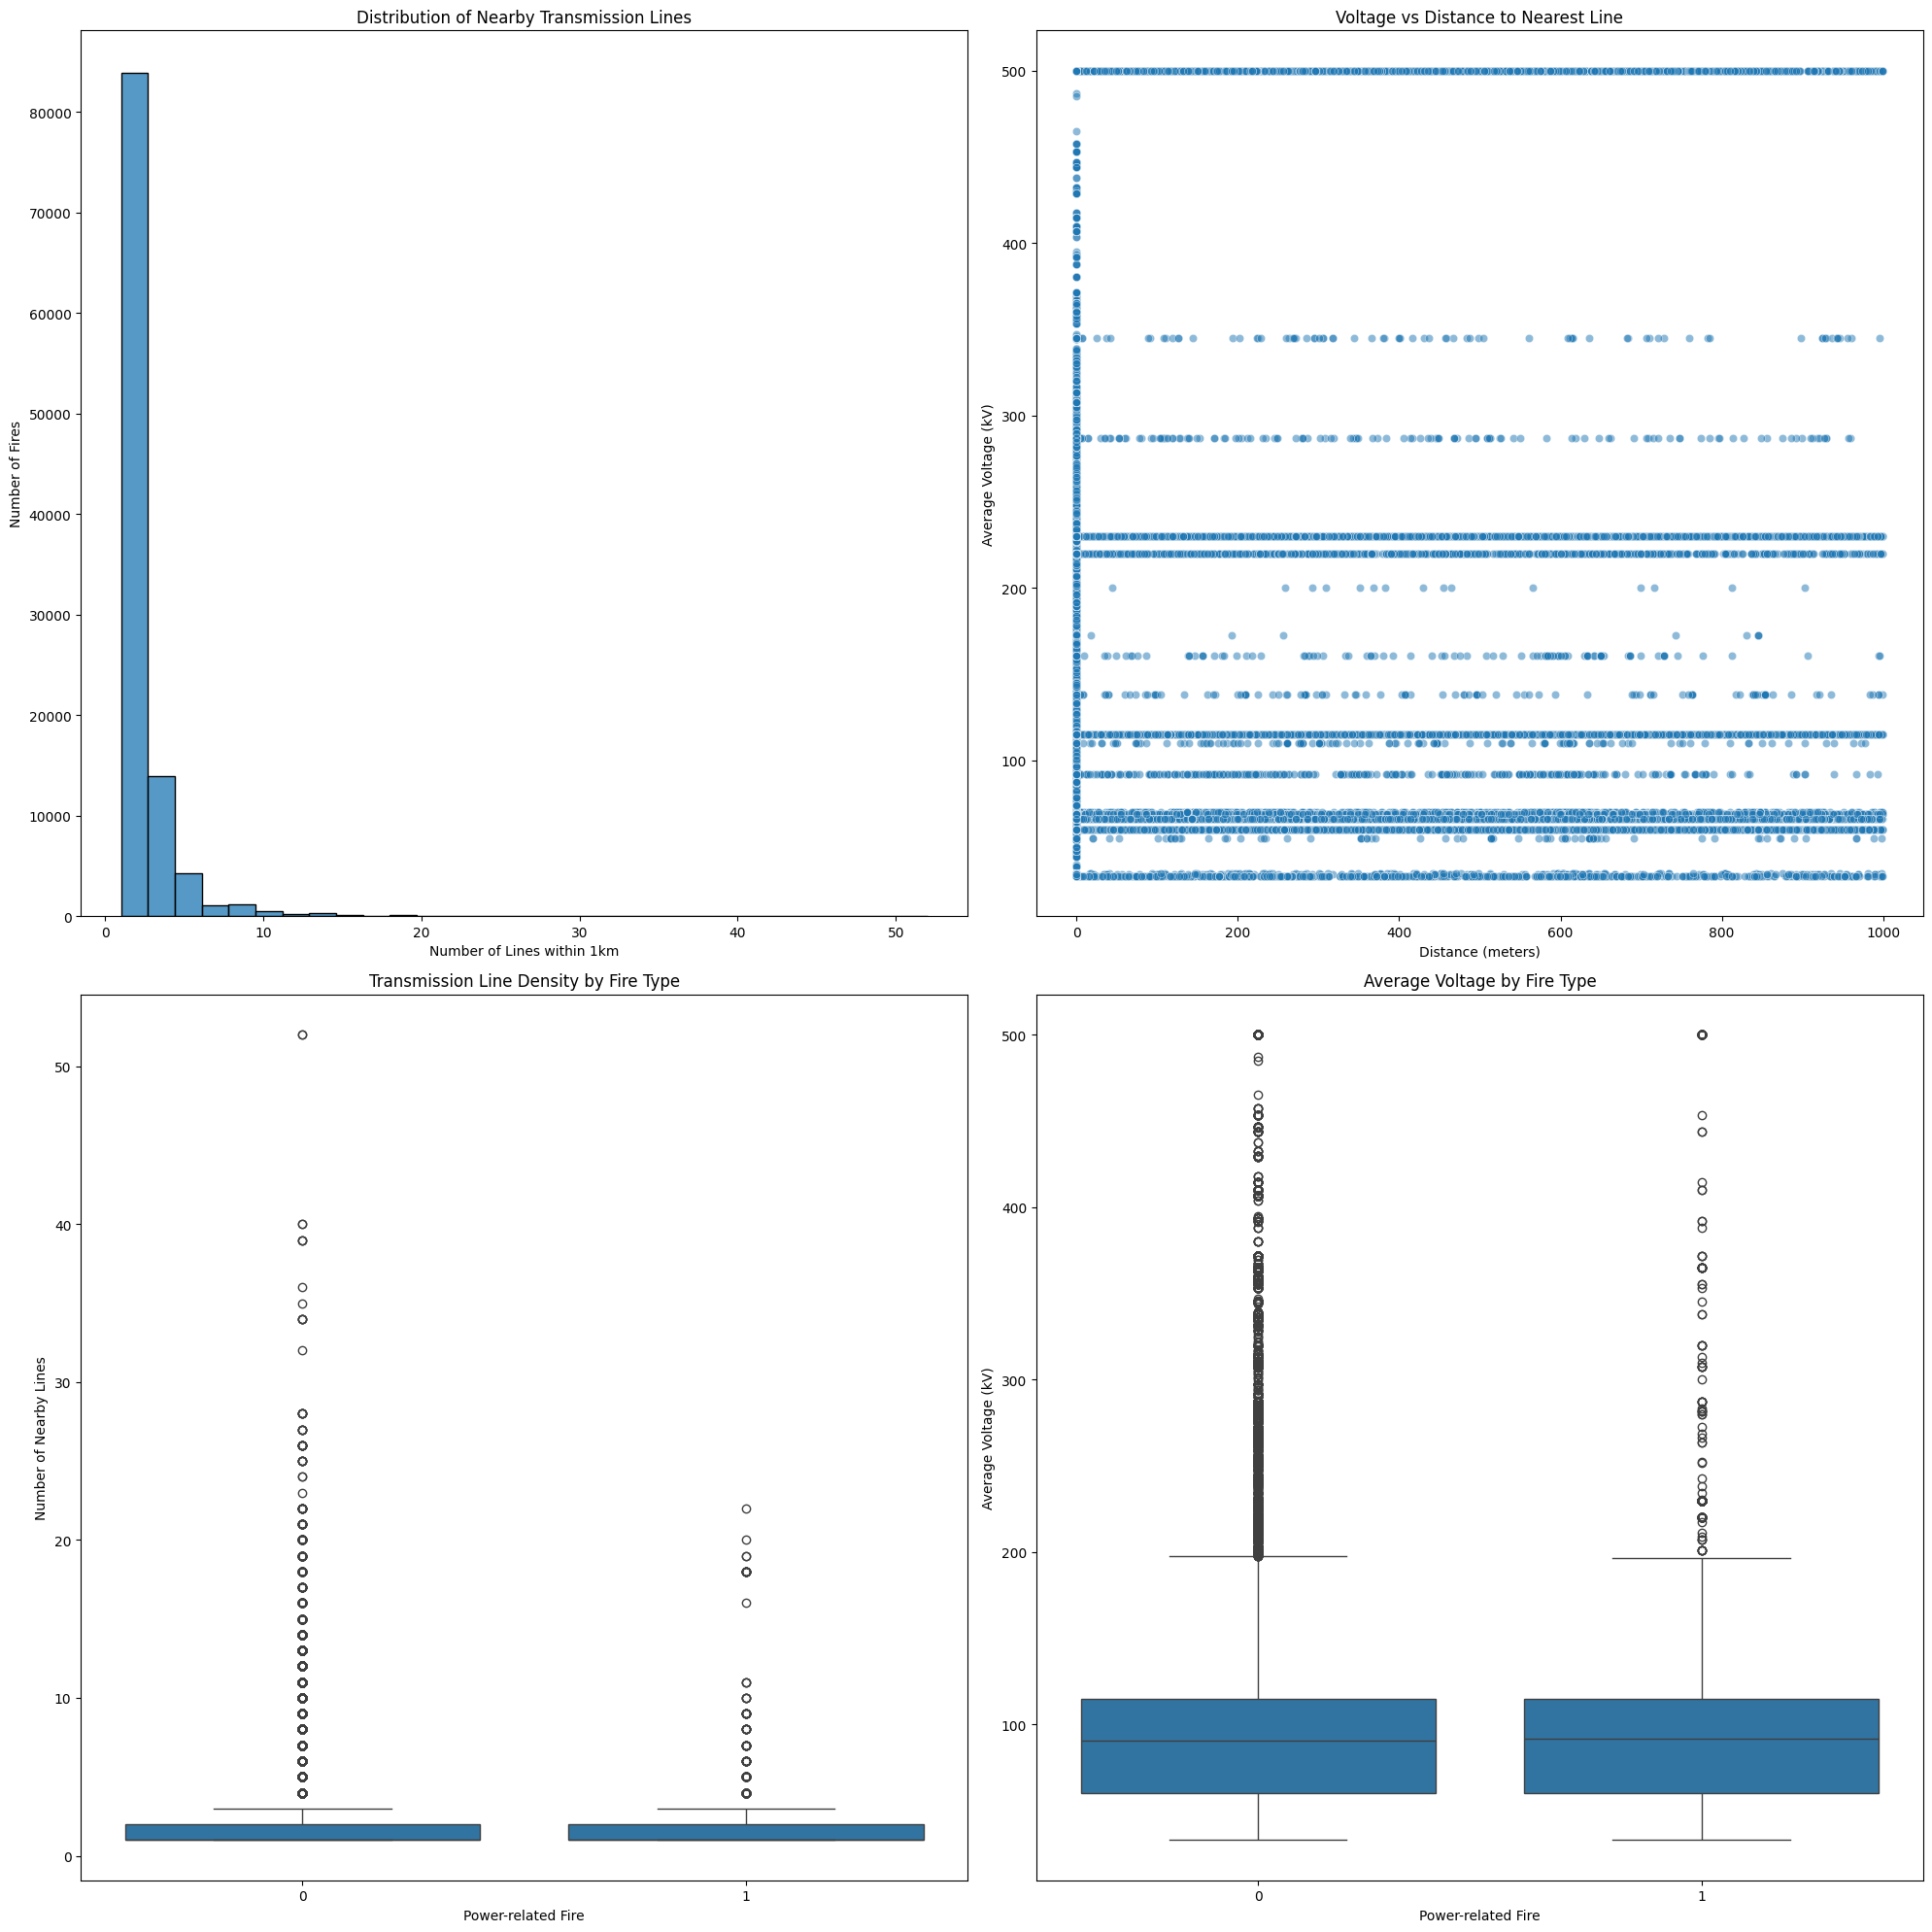


Transmission Line Density Summary:

Fires by number of nearby lines:
nearby_line_count
0    78259
1    65803
2    18103
3     9104
4     4785
Name: count, dtype: int64

Power-related fires by number of nearby lines:
nearby_line_count
0    1257
1    1171
2     342
3     134
4      74
Name: count, dtype: int64

Average number of nearby lines by fire type:
is_power_related
0    1.125437
1    1.180502
Name: nearby_line_count, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import HeatMap

# Load the merged data
merged_data = pd.read_csv('../data/processed/merged_data_with_density.csv')

# Create multiple visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# 1. Distribution of transmission line density
sns.histplot(
    data=merged_data[merged_data['nearby_line_count'] > 0],
    x='nearby_line_count',
    bins=30,
    ax=axes[0,0]
)
axes[0,0].set_title('Distribution of Nearby Transmission Lines')
axes[0,0].set_xlabel('Number of Lines within 1km')
axes[0,0].set_ylabel('Number of Fires')

# 2. Relationship between voltage and distance
sns.scatterplot(
    data=merged_data[merged_data['nearby_line_count'] > 0],
    x='min_distance_to_line',
    y='avg_voltage',
    alpha=0.5,
    ax=axes[0,1]
)
axes[0,1].set_title('Voltage vs Distance to Nearest Line')
axes[0,1].set_xlabel('Distance (meters)')
axes[0,1].set_ylabel('Average Voltage (kV)')

# 3. Power-related fires by line density
sns.boxplot(
    data=merged_data[merged_data['nearby_line_count'] > 0],
    x='is_power_related',
    y='nearby_line_count',
    ax=axes[1,0]
)
axes[1,0].set_title('Transmission Line Density by Fire Type')
axes[1,0].set_xlabel('Power-related Fire')
axes[1,0].set_ylabel('Number of Nearby Lines')

# 4. Voltage distribution by fire type
sns.boxplot(
    data=merged_data[merged_data['nearby_line_count'] > 0],
    x='is_power_related',
    y='avg_voltage',
    ax=axes[1,1]
)
axes[1,1].set_title('Average Voltage by Fire Type')
axes[1,1].set_xlabel('Power-related Fire')
axes[1,1].set_ylabel('Average Voltage (kV)')

plt.tight_layout()
plt.show()

# Create a geographic visualization of fire density and transmission lines
# Let's focus on a specific year for clarity
year_data = merged_data[merged_data['FIRE_YEAR'] == 2020].copy()

# Create a map centered on California
m = folium.Map(location=[37.8, -120.5], zoom_start=6)

# Add fire locations as a heatmap
locations = year_data[['LATITUDE', 'LONGITUDE', 'nearby_line_count']].values.tolist()
HeatMap(locations).add_to(m)

# Save the map
m.save('fire_density_map_2020.html')

# Print some summary statistics
print("\nTransmission Line Density Summary:")
print("\nFires by number of nearby lines:")
print(merged_data['nearby_line_count'].value_counts().sort_index().head())

print("\nPower-related fires by number of nearby lines:")
power_fires = merged_data[merged_data['is_power_related'] == 1]
print(power_fires['nearby_line_count'].value_counts().sort_index().head())

print("\nAverage number of nearby lines by fire type:")
print(merged_data.groupby('is_power_related')['nearby_line_count'].mean())

#### Key Insights of the dataset:

Distribution of Transmission Lines:

 1. Most fires (78,259) have no transmission lines within 1km
 2. Of those with nearby lines, most have 1-2 lines (83,906 fires)
 3. There are some extreme cases with up to 50+ lines nearby
 4. The distribution is heavily right-skewed


Voltage vs Distance Patterns:

 1. Clear voltage tiers are visible (horizontal lines in the scatter plot)
 2. Major voltage levels appear to be around 500kV, 300kV, 230kV, and 115kV
 3. Distribution of distances appears relatively uniform up to 1000m
 4. No clear relationship between voltage level and distance


Power-related Fires:

 1. Similar distribution of nearby lines between power-related and non-power-related fires
 2. Slightly higher average number of nearby lines for power-related fires (1.18 vs 1.13)
 3. Power-related fires have similar voltage distributions to non-power-related fires
 4. Of the 3,108 power-related fires:
     - 1,257 (40.4%) had no nearby lines within 1km
     - 1,171 (37.7%) had one nearby line
     - 342 (11%) had two nearby lines

In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the data
merged_data = pd.read_csv('../data/processed/merged_data_with_density.csv')

# 1. Create voltage categories based on observed tiers
def categorize_voltage(voltage):
    if pd.isna(voltage):
        return 'No Line'
    elif voltage >= 450:  # ~500kV tier
        return 'Extra High (>=450kV)'
    elif voltage >= 250:  # ~300kV tier
        return 'Very High (250-449kV)'
    elif voltage >= 200:  # ~230kV tier
        return 'High (200-249kV)'
    elif voltage >= 100:  # ~115kV tier
        return 'Medium (100-199kV)'
    else:
        return 'Low (<100kV)'

# 2. Create distance categories
def categorize_distance(distance):
    if pd.isna(distance):
        return 'No Line'
    elif distance == 0:
        return 'Immediate Proximity'
    elif distance < 100:
        return '<100m'
    elif distance < 500:
        return '100-500m'
    else:
        return '>500m'

# Apply transformations
cleaned_data = merged_data.copy()

# Handle dates
cleaned_data['DISCOVERY_DATE'] = pd.to_datetime(cleaned_data['DISCOVERY_DATE'])
cleaned_data['CONT_DATE'] = pd.to_datetime(cleaned_data['CONT_DATE'])
cleaned_data['fire_duration'] = (cleaned_data['CONT_DATE'] - cleaned_data['DISCOVERY_DATE']).dt.total_seconds() / (24 * 60 * 60)

# Create new features
cleaned_data['voltage_category'] = cleaned_data['avg_voltage'].apply(categorize_voltage)
cleaned_data['distance_category'] = cleaned_data['min_distance_to_line'].apply(categorize_distance)
cleaned_data['log_nearby_lines'] = np.log1p(cleaned_data['nearby_line_count'])
cleaned_data['has_transmission_line'] = (cleaned_data['nearby_line_count'] > 0).astype(int)

# Create season feature
cleaned_data['month'] = cleaned_data['DISCOVERY_DATE'].dt.month
cleaned_data['season'] = pd.cut(cleaned_data['month'], 
                              bins=[0, 3, 6, 9, 12], 
                              labels=['Winter', 'Spring', 'Summer', 'Fall'])

# Create interaction features
cleaned_data['voltage_distance_interaction'] = cleaned_data['avg_voltage'] * cleaned_data['min_distance_to_line']
cleaned_data['density_voltage_interaction'] = cleaned_data['nearby_line_count'] * cleaned_data['avg_voltage']

# Handle missing values
numeric_cols = ['air', 'soilm', 'vwnd', 'EVI_max', 'EVI_mean', 'NDVI_max', 'NDVI_mean']
cleaned_data[numeric_cols] = cleaned_data[numeric_cols].fillna(cleaned_data[numeric_cols].mean())

# Create dummy variables for categorical features
categorical_cols = ['voltage_category', 'distance_category', 'season', 'FIRE_SIZE_CLASS']
cleaned_data_encoded = pd.get_dummies(cleaned_data, columns=categorical_cols, drop_first=True)

# Scale numeric features
scaler = StandardScaler()
numeric_features = ['fire_duration', 'min_distance_to_line', 'avg_voltage', 
                   'log_nearby_lines'] + numeric_cols
scaled_features = scaler.fit_transform(cleaned_data_encoded[numeric_features])
cleaned_data_encoded[numeric_features] = scaled_features

# Print summary of changes
print("Original shape:", merged_data.shape)
print("Cleaned shape:", cleaned_data_encoded.shape)
print("\nNew features created:")
print("Numeric features:", len(numeric_features))
print("Categorical features encoded:", len(categorical_cols))

# Basic data quality checks
print("\nMissing values after cleaning:")
print(cleaned_data_encoded.isnull().sum().sum())

# Save cleaned dataset
cleaned_data_encoded.to_csv('../data/processed/cleaned_data_final.csv', index=False)
cleaned_data.to_csv('../data/processed/cleaned_data_with_categories.csv', index=False)

# Print sample of transformations
print("\nSample of categorical transformations:")
sample_data = cleaned_data[['voltage_category', 'distance_category', 
                           'nearby_line_count', 'log_nearby_lines']].head()
print(sample_data)

# Summary statistics for new features
print("\nSummary statistics for new numeric features:")
numeric_summary = cleaned_data[['log_nearby_lines', 'fire_duration', 
                              'voltage_distance_interaction']].describe()
print(numeric_summary)

# Distribution of categorical features
print("\nDistribution of voltage categories:")
print(cleaned_data['voltage_category'].value_counts())
print("\nDistribution of distance categories:")
print(cleaned_data['distance_category'].value_counts())

/var/folders/4c/0zt2zr712xn0rtz1d_xhxpgm0000gn/T/ipykernel_8059/2408795837.py:6: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_data = pd.read_csv('../data/processed/merged_data_with_density.csv')
/var/folders/4c/0zt2zr712xn0rtz1d_xhxpgm0000gn/T/ipykernel_8059/2408795837.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cleaned_data['DISCOVERY_DATE'] = pd.to_datetime(cleaned_data['DISCOVERY_DATE'])
/var/folders/4c/0zt2zr712xn0rtz1d_xhxpgm0000gn/T/ipykernel_8059/2408795837.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cleaned_data['CONT_DATE'] = pd.to_datetime(cleaned_data['CONT_DATE'])


Original shape: (183884, 33)
Cleaned shape: (183884, 56)

New features created:
Numeric features: 11
Categorical features encoded: 4

Missing values after cleaning:
812078

Sample of categorical transformations:
   voltage_category    distance_category  nearby_line_count  log_nearby_lines
0      Low (<100kV)  Immediate Proximity                  1          0.693147
1  High (200-249kV)                >500m                  1          0.693147
2  High (200-249kV)  Immediate Proximity                  1          0.693147
3           No Line              No Line                  0          0.000000
4           No Line              No Line                  0          0.000000

Summary statistics for new numeric features:
       log_nearby_lines  fire_duration  voltage_distance_interaction
count     183884.000000  107485.000000                 105625.000000
mean           0.555277       0.768116                  17247.042391
std            0.577463       6.461920                  46157.32517

In [8]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
env_data = pd.read_csv("../data/processed/environmental_data_cleaned.csv", low_memory=False)
fire_data = pd.read_csv("../data/processed/fire_data.csv", low_memory=False)
transmission_data = gpd.read_file('../data/processed/transmission_data_cleaned.geojson')

# Convert env_data columns to numeric
numeric_cols = ['air', 'soilm', 'vwnd', 'EVI_max', 'EVI_mean', 'NDVI_max', 'NDVI_mean']
for col in numeric_cols:
    env_data[col] = pd.to_numeric(env_data[col], errors='coerce')

# Extract year from fire data
fire_data['FIRE_YEAR'] = pd.to_datetime(fire_data['DISCOVERY_DATE']).dt.year

# Round coordinates to 0.1-degree resolution
env_data['lat_grid'] = np.round(env_data['lat'] * 10) / 10
env_data['lon_grid'] = np.round(env_data['lon'] * 10) / 10
fire_data['lat_grid'] = np.round(fire_data['LATITUDE'] * 10) / 10
fire_data['lon_grid'] = np.round(fire_data['LONGITUDE'] * 10) / 10

# Create grid-year combination
years = range(2000, 2021)
grid_points = env_data[['lat_grid', 'lon_grid']].drop_duplicates()

print("Number of unique grid points:", len(grid_points))

# Create yearly grid points
grid_years = []
for year in years:
    year_points = grid_points.copy()
    year_points['year'] = year
    grid_years.append(year_points)

grid_years_df = pd.concat(grid_years, ignore_index=True)

# Aggregate environmental data by grid cell
env_agg = env_data.groupby(['lat_grid', 'lon_grid'])[numeric_cols].agg({
    'air': 'mean',
    'soilm': 'mean',
    'vwnd': 'mean',
    'EVI_max': 'max',
    'EVI_mean': 'mean',
    'NDVI_max': 'max',
    'NDVI_mean': 'mean'
}).reset_index()

print("Shape of aggregated environmental data:", env_agg.shape)

# Mark fire occurrences
fire_locations = fire_data.groupby(['lat_grid', 'lon_grid', 'FIRE_YEAR']).size().reset_index()
fire_locations.columns = ['lat_grid', 'lon_grid', 'year', 'fire_count']

# Merge with grid_years_df
grid_years_df = grid_years_df.merge(
    fire_locations[['lat_grid', 'lon_grid', 'year', 'fire_count']],
    how='left',
    on=['lat_grid', 'lon_grid', 'year']
)

# Create binary target
grid_years_df['had_fire'] = grid_years_df['fire_count'].notna().astype(int)

# Merge environmental data
grid_years_df = grid_years_df.merge(
    env_agg,
    on=['lat_grid', 'lon_grid'],
    how='left'
)

print("Shape after merging environmental data:", grid_years_df.shape)

# Convert to GeoDataFrame for spatial join
env_gdf = gpd.GeoDataFrame(
    grid_years_df,
    geometry=gpd.points_from_xy(grid_years_df.lon_grid, grid_years_df.lat_grid),
    crs="EPSG:4326"  # WGS 84
)

# Project to California Albers
env_gdf = env_gdf.to_crs("EPSG:3310")

# Make sure transmission data is in the same CRS
if transmission_data.crs != "EPSG:3310":
    transmission_data = transmission_data.to_crs("EPSG:3310")

print("CRS check:")
print("Environmental data CRS:", env_gdf.crs)
print("Transmission data CRS:", transmission_data.crs)

# Create buffer for transmission lines (now in meters since we're using Albers)
transmission_buffer = transmission_data.copy()
transmission_buffer['geometry'] = transmission_data.geometry.buffer(1000)  # 1km buffer

transmission_features = [
    'geometry', 'kV_Sort', 'Length_Mile', 'line_age_years',
    'is_operational', 'is_overhead', 'nearby_line_count',
    'nearby_total_length', 'nearby_avg_voltage', 'nearby_max_voltage',
    'maintenance_frequency'
]

# Spatial join with transmission data
final_data = gpd.sjoin_nearest(
    env_gdf,
    transmission_buffer[transmission_features],
    how='left',
    max_distance=1000
)

print("\nFinal dataset shape:", final_data.shape)
print("Class distribution:")
print(final_data['had_fire'].value_counts(normalize=True))

# Save the processed dataset
final_data.drop('geometry', axis=1).to_csv('grid_fire_data.csv', index=False)
print("\nData saved to 'grid_fire_data.csv'")

# Print sample of the data
print("\nSample of final dataset:")
print(final_data.drop('geometry', axis=1).head())

/var/folders/4c/0zt2zr712xn0rtz1d_xhxpgm0000gn/T/ipykernel_17111/1710736454.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fire_data['FIRE_YEAR'] = pd.to_datetime(fire_data['DISCOVERY_DATE']).dt.year


Number of unique grid points: 1085
Shape of aggregated environmental data: (1085, 9)
Shape after merging environmental data: (22785, 12)
CRS check:
Environmental data CRS: EPSG:3310
Transmission data CRS: EPSG:3310

Final dataset shape: (23982, 24)
Class distribution:
had_fire
0    0.796139
1    0.203861
Name: proportion, dtype: float64

Data saved to 'grid_fire_data.csv'

Sample of final dataset:
   lat_grid  lon_grid  year  fire_count  had_fire         air       soilm  \
0      32.0    -115.4  2000         NaN         0  289.024141  314.863042   
1      32.1    -115.1  2000         NaN         0  289.024141  314.863042   
2      32.1    -114.8  2000         NaN         0  288.714213  332.202335   
3      32.1    -114.4  2000         NaN         0  289.927912  404.116685   
4      32.1    -114.1  2000         NaN         0  289.927912  404.116685   

       vwnd  EVI_max  EVI_mean  ...  kV_Sort  Length_Mile  line_age_years  \
0 -0.930089   0.9996  0.183015  ...      NaN          NaN  

Total grid points: 1085
Grid points within California: 410


<Figure size 1500x1500 with 0 Axes>

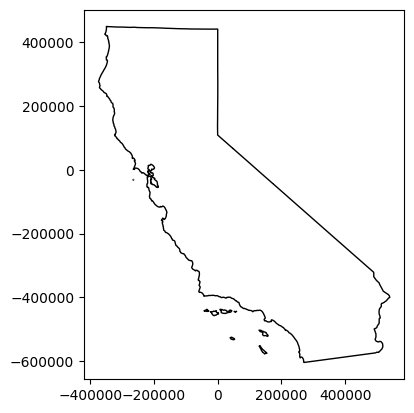

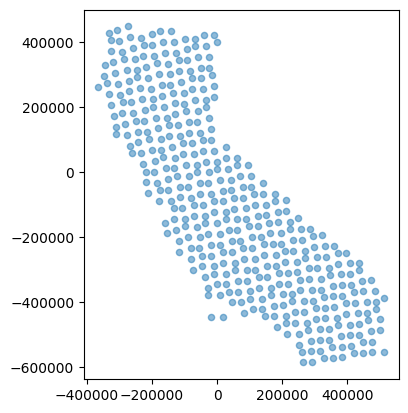

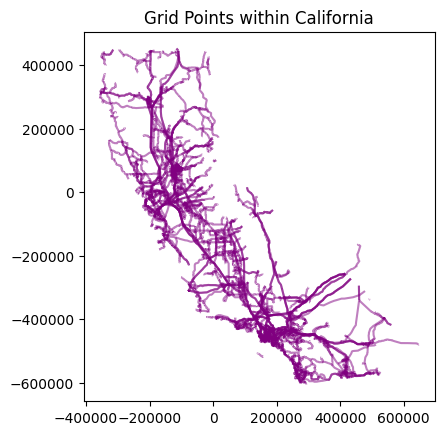

In [10]:
import geopandas as gpd

# Read California boundary
california = gpd.read_file('../data/CA/california.geojson')

# Now let's modify our previous code with the CA boundary
# Create GeoDataFrame from grid points
env_gdf = gpd.GeoDataFrame(
    grid_points,
    geometry=gpd.points_from_xy(grid_points.lon_grid, grid_points.lat_grid),
    crs="EPSG:4326"
).to_crs("EPSG:3310")

# Clip grid points to California boundary
california = california.to_crs("EPSG:3310")
env_gdf = gpd.sjoin(env_gdf, california, how='inner', predicate='within')

print("Total grid points:", len(grid_points))
print("Grid points within California:", len(env_gdf))

# Visualize to verify
plt.figure(figsize=(15, 15))
california.boundary.plot(color='black', linewidth=1)
env_gdf.plot(alpha=0.5, markersize=20)
transmission_data.plot(color='purple', alpha=0.5)
plt.title('Grid Points within California')
plt.show()

In [ ]:
# Instead of using individual points of the lines, let's first dissolve/merge 
# transmission lines that are connected or overlapping
transmission_dissolved = transmission_data.copy()
transmission_dissolved['dissolve_key'] = 1  # Same key for all to merge everything
transmission_dissolved = transmission_dissolved.dissolve(by='dissolve_key')

# Now try different buffer distances
buffer_distances = [1000, 2000, 5000, 10000]  # meters

coverage_analysis = []
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.ravel()

for idx, distance in enumerate(buffer_distances):
    # Create buffer for transmission lines
    transmission_buffer = transmission_dissolved.copy()
    transmission_buffer['geometry'] = transmission_dissolved.geometry.buffer(distance)
    
    # Create a binary mask of grid points that fall within the buffer
    grid_within_buffer = gpd.sjoin(
        env_gdf,
        transmission_buffer,
        how='left',
        predicate='within'
    )
    
    # Calculate coverage
    cells_near_lines = grid_within_buffer.index.nunique()
    coverage_percent = (cells_near_lines / len(env_gdf)) * 100
    
    # Plot
    ax = axes[idx]
    
    # Plot California boundary
    california.boundary.plot(ax=ax, color='black', linewidth=1)
    
    # Plot transmission lines
    transmission_data.plot(ax=ax, color='purple', alpha=0.5)
    
    # Create color array for grid points
    is_near_line = np.isin(env_gdf.index, grid_within_buffer.index)
    colors = np.where(is_near_line, 'red', 'blue')
    
    # Plot grid points
    env_gdf.plot(
        ax=ax,
        color=colors,
        alpha=0.5,
        markersize=20
    )
    
    ax.set_title(f'Buffer Distance: {distance/1000}km\nCoverage: {coverage_percent:.1f}%')

plt.tight_layout()
plt.show()

print("\nCoverage Analysis by Buffer Distance:")
print(pd.DataFrame(coverage_analysis))

# Print additional statistics
print("\nDetailed Statistics:")
for distance, analysis in zip(buffer_distances, coverage_analysis):
    print(f"\nAt {distance/1000}km buffer:")
    print(f"Number of grid cells near lines: {analysis['cells_near_lines']}")
    print(f"Percentage coverage: {analysis['coverage_percent']:.2f}%")

Creating grid...
Created 4432 grid cells

Processing environmental data...

Processing fire data...

Processing transmission lines...

Merging datasets...

Final dataset summary:
Total grid cells: 42600
Cells with fires: 41943
Cells with transmission lines: 0


/var/folders/4c/0zt2zr712xn0rtz1d_xhxpgm0000gn/T/ipykernel_17111/3953267261.py:60: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3310

  grid_trans = gpd.sjoin(grid_gdf, transmission_gdf, how='left', predicate='intersects')


<Figure size 1500x1500 with 0 Axes>

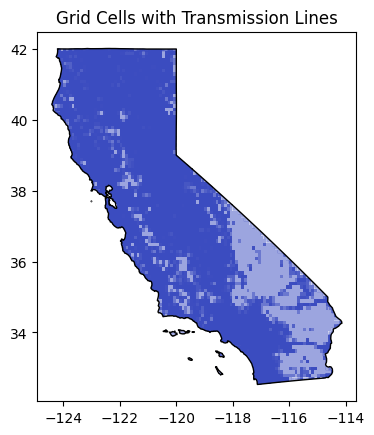

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box, Polygon

# 1. Create grid cells for California
def create_california_grid(california_gdf, resolution=0.1):
    # Get California bounds
    minx, miny, maxx, maxy = california_gdf.total_bounds
    
    # Create grid cells
    grid_cells = []
    for x0 in np.arange(minx, maxx, resolution):
        for y0 in np.arange(miny, maxy, resolution):
            x1 = x0 + resolution
            y1 = y0 + resolution
            cell = box(x0, y0, x1, y1)
            grid_cells.append({
                'geometry': cell,
                'lon_min': x0,
                'lon_max': x1,
                'lat_min': y0,
                'lat_max': y1,
                'grid_id': f"{x0:.1f}_{y0:.1f}"
            })
    
    # Create GeoDataFrame
    grid_gdf = gpd.GeoDataFrame(grid_cells, crs="EPSG:4326")
    
    # Clip to California boundary
    grid_gdf = gpd.clip(grid_gdf, california_gdf)
    
    return grid_gdf

# 2. Function to assign data to grid cells
def assign_to_grid(data, grid_gdf, lat_col, lon_col):
    """
    Assign points to grid cells based on lat/lon
    """
    data = data.copy()
    data['grid_id'] = None
    
    for idx, grid_cell in grid_gdf.iterrows():
        mask = (
            (data[lon_col] >= grid_cell['lon_min']) & 
            (data[lon_col] < grid_cell['lon_max']) &
            (data[lat_col] >= grid_cell['lat_min']) & 
            (data[lat_col] < grid_cell['lat_max'])
        )
        data.loc[mask, 'grid_id'] = grid_cell['grid_id']
    
    return data

# 3. Function to process transmission lines
def process_transmission_lines(transmission_gdf, grid_gdf):
    """
    Determine which grid cells contain or intersect with transmission lines
    """
    # Spatial join between grid and transmission lines
    grid_trans = gpd.sjoin(grid_gdf, transmission_gdf, how='left', predicate='intersects')
    
    # Aggregate transmission line information by grid cell
    grid_trans_agg = grid_trans.groupby('grid_id').agg({
        'kV_Sort': 'mean',
        'Length_Mile': 'sum',
        'nearby_line_count': 'max',
        'maintenance_frequency': 'mean'
    }).reset_index()
    
    return grid_trans_agg

# Main processing
# Load California boundary
california = gpd.read_file('../data/CA/california.geojson')

# Create grid
print("Creating grid...")
grid = create_california_grid(california)
print(f"Created {len(grid)} grid cells")

# Assign environmental data to grid
print("\nProcessing environmental data...")
env_data_with_grid = assign_to_grid(env_data, grid, 'lat', 'lon')
env_grid_agg = env_data_with_grid.groupby('grid_id').agg({
    'air': 'mean',
    'soilm': 'mean',
    'vwnd': 'mean',
    'EVI_max': 'max',
    'EVI_mean': 'mean',
    'NDVI_max': 'max',
    'NDVI_mean': 'mean'
}).reset_index()

# Assign fire data to grid
print("\nProcessing fire data...")
fire_data_with_grid = assign_to_grid(fire_data, grid, 'LATITUDE', 'LONGITUDE')
fire_grid_agg = fire_data_with_grid.groupby(['grid_id', 'FIRE_YEAR']).size().reset_index(name='fire_count')

# Process transmission lines
print("\nProcessing transmission lines...")
trans_grid_info = process_transmission_lines(transmission_data, grid)

# Merge all data
print("\nMerging datasets...")
grid_merged = grid.merge(env_grid_agg, on='grid_id', how='left')
grid_merged = grid_merged.merge(fire_grid_agg, on='grid_id', how='left')
grid_merged = grid_merged.merge(trans_grid_info, on='grid_id', how='left')

# Fill NaN values appropriately
grid_merged['fire_count'] = grid_merged['fire_count'].fillna(0)
grid_merged['has_transmission'] = grid_merged['kV_Sort'].notna().astype(int)

# Print summary
print("\nFinal dataset summary:")
print(f"Total grid cells: {len(grid_merged)}")
print(f"Cells with fires: {(grid_merged['fire_count'] > 0).sum()}")
print(f"Cells with transmission lines: {grid_merged['has_transmission'].sum()}")

# Visualize
plt.figure(figsize=(15, 15))
grid_merged.plot(column='has_transmission', cmap='coolwarm', alpha=0.5)
california.boundary.plot(ax=plt.gca(), color='black', linewidth=1)
plt.title('Grid Cells with Transmission Lines')
plt.show()

# Save the processed data
grid_merged.to_file('california_grid_data.geojson')

In [9]:
import pandas as pd

# Load the dataset
data = pd.read_csv('grid_fire_data.csv')

# Preprocessing for existing features
for col in ['soilm', 'air', 'vwnd', 'EVI_mean', 'NDVI_mean']:
    data[col] = data.groupby('year')[col].transform(lambda x: x.fillna(x.mean()))

for col in ['EVI_max', 'NDVI_max']:
    data[col] = data.groupby('year')[col].transform(lambda x: x.fillna(x.max()))

data['fire_count'] = data['fire_count'].fillna(0)
data['index_right'] = data['index_right'].fillna(0)
data['kV_Sort'] = data['kV_Sort'].fillna(0)
data['nearby_line_count'] = data['nearby_line_count'].fillna(0)
data['maintenance_frequency'] = data['maintenance_frequency'].fillna(0)

# Preprocessing for new transmission features
transmission_features = {
    'kV_Sort': 0,
    'Length_Mile': 0,
    'line_age_years': 0,
    'is_operational': 0,
    'is_overhead': 0,
    'nearby_line_count': 0,
    'nearby_total_length': 0,
    'nearby_avg_voltage': 0,
    'nearby_max_voltage': 0,
    'maintenance_frequency': 0
}

# Fill missing values for the transmission features
for feature, fill_value in transmission_features.items():
    data[feature] = data[feature].fillna(fill_value)

# Save the cleaned dataset
data.to_csv('grid_fire_data_corrected_cleaned.csv', index=False)

print("Missing values handled and data saved to 'grid_fire_data_cleaned.csv'")


Missing values handled and data saved to 'grid_fire_data_cleaned.csv'
